# Environment Setup

In [1]:
import os
import sys
from dotenv import load_dotenv

# Load environment variables from `.env` file for database URL. Check README for the setup guide.
load_dotenv()

# Ignore SQLAlchemy version warning for this project.
os.environ['SQLALCHEMY_SILENCE_UBER_WARNING'] = '1'

In [2]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import psycopg2
import matplotlib.pyplot as plt
import itertools
from collections import defaultdict
import time
import re
import math
import copy

# Database Connection

In [3]:
DATABASE_URL = os.environ['DATABASE_URL']
if not DATABASE_URL:
    print('Check README file for environment setup')
    sys.exit(1)
engine = create_engine(DATABASE_URL)

In [4]:
try:
    result = engine.execute("SELECT 1")
    print("✅ Connection successful!")
except Exception as e:
    print("🔴 Connection failed:", e)
    sys.exit(1)

✅ Connection successful!


# Hyperparameters

In [5]:
# Hyperparameters
delta = 0.0001
k = 5
num_phases = 5  # This value should align with the data. It should not be changed unless you build your own data.

# Math Util Functions

In [6]:
def kl_divergence(p, q):
    epsilon = 1e-10  # A small-enough constant for avoiding computational error.
    p = np.where(p == 0, epsilon, p)
    q = np.where(q == 0, epsilon, q)
    return np.sum(p * np.log(p / q))

In [7]:
def epsilon_m(m: int, N: int):
    """
    Calculate the epsilon value for the confidence interval pruning method.

    Parameters
    ----------
    m : int
        The number of items in the sample.
    N : int
        The number of items in the population.
    """
    upper_left = 1 - (m - 1) / N
    # Using log log m is problematic when m=1. So we change it to log m for now.
    upper_right = 2 * np.log(m) + np.log((np.pi ** 2) / (3 * delta))
    bottom = 2 * m
    return np.sqrt(upper_left * upper_right / bottom)

# Query Generations

In [8]:
import itertools

# These are all available candidates for (attribute, measurement, function) combinations.
dimensions = ['workclass', 'education', 'occupation', 'relationship', 'race', 'sex', 'native_country', 'income']
measurements = ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
aggregate_functions = ['count', 'max', 'min', 'sum', 'avg']

# Iterate through the cross product of three lists to build all views.
# We use list instead of dict or set here for the ordering consistency. The hashing might cause ordering issues.
views = list()
for dimension, measurement, function in itertools.product(dimensions, measurements, aggregate_functions):
    views.append((dimension, measurement, function))

In [9]:
def generate_queries(candidate_views: list):
    """
    This function is used to generate queries based off the current candidate views.

    Parameters
    ----------
    candidate_views
        The modified dictionary of views after pruning views in the end of every phase.
    """
    married_query_list = []
    unmarried_query_list = []
    for (attribute, measurement, function) in candidate_views:
        married_query_list.append(f"SELECT {attribute}, {function}({measurement}) AS {function}_{measurement} FROM married_data WHERE {attribute} IS NOT NULL GROUP BY {attribute};")
        unmarried_query_list.append(f"SELECT {attribute}, {function}({measurement}) AS {function}_{measurement} FROM unmarried_data WHERE {attribute} IS NOT NULL GROUP BY {attribute};")
    return married_query_list, unmarried_query_list

# Baseline (Non-optimizing)

In [10]:
def baseline():
    # Generate queries based on all views (no partitioning).
    raw_queries_married, raw_queries_unmarried = generate_queries(views)

    # Query data from database and store them into `results` variable.
    results = []
    for raw_query_married, raw_query_unmarried in zip(raw_queries_married, raw_queries_unmarried):
        # Run raw query on both married and unmarried data.
        df_married = pd.read_sql_query(raw_query_married, engine)
        df_unmarried = pd.read_sql_query(raw_query_unmarried, engine)
        # Set them as a tuple for later utility computation.
        results.append((df_married, df_unmarried))

    # Storing scores across phases, where key = (a,m,f) and value = KL.
    view_scores = dict()

    # Align views with results, and compute utility scores (KL).
    for (attribute, measurement, function), (df_married, df_unmarried) in zip(views, results):
        # Collects unique values of this attribute from both married and unmarried dataframes.
        all_attribute_values = set(df_married[attribute].unique()).union(set(df_unmarried[attribute].unique()))
        
        # Organize data and ensure all possible attribute values are included using reindex function.
        grouped_married = df_married.groupby(attribute).agg({f'{function}_{measurement}': 'sum'}).reindex(all_attribute_values, fill_value=0)
        grouped_unmarried = df_unmarried.groupby(attribute).agg({f'{function}_{measurement}': 'sum'}).reindex(all_attribute_values, fill_value=0)
        
        # Compute sum for normalization.
        total_married = grouped_married[f'{function}_{measurement}'].sum()
        total_unmarried = grouped_unmarried[f'{function}_{measurement}'].sum()

        # Get KL score after normalizing data and store it into `view_scores` dict.
        p = (grouped_married / total_married).fillna(0).values.flatten()
        q = (grouped_unmarried / total_unmarried).fillna(0).values.flatten()
        score = kl_divergence(p, q)
        view_scores[(attribute, measurement, function)] = score

    # Print top-k results.
    top_scores = sorted(view_scores.items(), key=lambda x: x[1], reverse=True)[:k]
    for key, score in top_scores:
        print(f"View: {key}, Score: {score}")

    return top_scores

# Section 4.1: Sharing-based Optimizations

## Basic Aggregation Combinations

In [11]:
# The following functions can generated the combined queries.

import re
from collections import defaultdict

function_lst = ['SUM', 'COUNT', 'AVG', 'MAX', 'MIN']

select_pattern = r"SELECT\s+(.*?)\s+FROM"
from_pattern = r"FROM\s+(.*?)(?:\s+WHERE|\s+GROUP\s+BY|$)"
where_pattern = r"WHERE\s+(.*?)(?:\s+GROUP\s+BY|$)"
group_by_pattern = r"GROUP\s+BY\s+(.*)"


def parseQuery(query):
    select_match = re.search(select_pattern, query, re.IGNORECASE)
    from_match = re.search(from_pattern, query, re.IGNORECASE)
    where_match = re.search(where_pattern, query, re.IGNORECASE)
    group_by_match = re.search(group_by_pattern, query, re.IGNORECASE)

    select_items = select_match.group(1) if select_match else ""
    from_items = from_match.group(1) if from_match else ""
    where_items = where_match.group(1) if where_match else ""
    group_by_items = group_by_match.group(1) if group_by_match else ""

    return select_items, from_items, where_items, group_by_items


def parseSelectItems(select_items):
    components = select_items.split(',')
    attribute = None
    measures, functions = [], []

    for component in components:
        component = component.strip()
        component_upper = component.upper()
        for func in function_lst:
            if func.upper() in component_upper:
                measure_match = re.search(rf"{func}\((.*?)\)", component, re.IGNORECASE)
                if measure_match:
                    measure = measure_match.group(1)
                    measures.append(measure)
                    functions.append(func)
                break
        else:
            attribute = component

    return attribute, measures, functions

def combineAggregates(queries, partition=None):
    # Group queries by FROM and WHERE clauses for potential combination
    query_groups = defaultdict(list)
    for query in queries:
        select_items, from_clause, where_clause, group_by_items = parseQuery(query.rstrip(';'))
        attribute, measures, functions = parseSelectItems(select_items)
        key = (from_clause, where_clause)
        query_groups[key].append((group_by_items, measures, functions, attribute))

    combined_queries = []
    for (from_clause, where_clause), group in query_groups.items():
        combined_by_group = defaultdict(list)
        for group_by_items, measures, functions, attribute in group:
            combined_by_group[group_by_items].append((measures, functions, attribute))

        for group_by_items, details in combined_by_group.items():
            select_parts = []
            for measures, functions, attribute in details:
                for measure, function in zip(measures, functions):
                    select_parts.append(f"{function}({measure}) AS {function}_{measure}")
            select_clause = ', '.join(select_parts)
            if partition is not None:
                partition_clause = f"partition_id = {partition}"
                where_clause = f"{where_clause} AND {partition_clause}" if where_clause else partition_clause
            where_clause = f"WHERE {where_clause}" if where_clause else ""
            group_by_clause = f"GROUP BY {group_by_items}" if group_by_items else ""
            query = f"SELECT {group_by_items}, {select_clause} FROM {from_clause} {where_clause} {group_by_clause};"
            combined_queries.append(query)

    return combined_queries


def decomposeAggTable(dimensions_name, combined_dataframe, individual_list):
    measurements = set(col.split('_')[1] for col in combined_dataframe.columns if '_' in col)

    # Create a dictionary to store each separate DataFrame
    separated_tables = {}

    for column in combined_dataframe.columns:
        if column != dimensions_name:
            # Properly split the column name
            parts = column.split('_')
            func = parts[0]  # The function is always the first part
            measure = '_'.join(parts[1:])  # The rest is the measurement name

            table_name = f"{func}_{measure}"  # Create a unique table name

            # Create a new DataFrame for this specific measurement and function
            separated_tables[table_name] = combined_dataframe[[dimensions_name, column]].copy()
            separated_tables[table_name].rename(columns={column: table_name}, inplace=True)

    # Printing or exporting the separated tables
    for table_name, df in separated_tables.items():
        individual_list.append(df)

## GROUP BY Combinations

In [12]:
# function to decompose the group by query

def calculate_mean_from_sum_count(sum_val, count_val):
    return sum_val / count_val if count_val != 0 else 0

def build_aggregation_dict(df):
    # dummy column for avg
    agg_dict = {
        'count':'sum',
        'max':'max',
        'min':'min',
        'sum':'sum',
        'avg':'mean' # dummy 
    }

    agg_funcs = {}
    mean_col_list = []

    for col in df.columns:
        if '_' in col and col!='native_country':
            func_suffix, base_name = col.split('_', 1)
            agg_funcs[col] = agg_dict[func_suffix]
    return agg_funcs


def decomposeGroupBy(combined_group_by_df, dimension_name):
    agg_funcs = build_aggregation_dict(combined_group_by_df)
        
    non_avg_grouped_df = combined_group_by_df.groupby(dimension_name, as_index=False).agg(agg_funcs)
    
    for col in non_avg_grouped_df.columns:
        if '_' in col:
            if 'avg' in col:
                _, base_name = col.split('_', 1)

                non_avg_grouped_df['avg_'+ base_name ] = non_avg_grouped_df['sum_'+ base_name] / non_avg_grouped_df['count_'+base_name]
    
    return non_avg_grouped_df

## Executor without GROUP BY Combinations

In [13]:
def sharing_based_optimizations_without_group_by_combinations():
    # Get raw queries (separate statements).
    raw_queries_married, raw_queries_unmarried = generate_queries(views)

    # Combine statements together (Section 4.1).
    combined_queries_married = combineAggregates(raw_queries_married)
    combined_queries_unmarried = combineAggregates(raw_queries_unmarried)

    # Run combined queries for both married and unmarried data.
    agg_opt_res = []
    for i in range(len(combined_queries_married)):
        df_married_agg_opt = pd.read_sql_query(combined_queries_married[i], engine)
        df_unmarried_agg_opt = pd.read_sql_query(combined_queries_unmarried[i], engine)
        agg_opt_res.append((df_married_agg_opt, df_unmarried_agg_opt))

    # Decompose combined queries back into original views.
    de_married_list = []
    de_unmarried_list = []
    for i in range(len(agg_opt_res)):
        dimensions_name = agg_opt_res[i][0].columns[0]
        married_combined_df = agg_opt_res[i][0]
        unmarried_combined_df = agg_opt_res[i][1]
        decomposeAggTable(dimensions_name, married_combined_df, de_married_list)
        decomposeAggTable(dimensions_name, unmarried_combined_df, de_unmarried_list)

    # Storing scores across phases, where key = (a,m,f) and value = KL.
    view_scores = dict()

    # Align views with results, and compute utility scores (KL).
    for (attribute, measurement, function), df_married, df_unmarried in zip(views, de_married_list, de_unmarried_list):            
        # Collects unique values of this attribute from both married and unmarried dataframes.
        all_attribute_values = set(df_married[attribute].unique()).union(set(df_unmarried[attribute].unique()))
        
        # Organize data and ensure all possible attribute values are included using reindex function.
        grouped_married = df_married.groupby(attribute).agg({f'{function}_{measurement}': 'sum'}).reindex(all_attribute_values, fill_value=0)
        grouped_unmarried = df_unmarried.groupby(attribute).agg({f'{function}_{measurement}': 'sum'}).reindex(all_attribute_values, fill_value=0)
        
        # Compute sum for normalization.
        total_married = grouped_married[f'{function}_{measurement}'].sum()
        total_unmarried = grouped_unmarried[f'{function}_{measurement}'].sum()

        # Get KL score after normalizing data and store it into `view_scores` dict.
        p = (grouped_married / total_married).fillna(0).values.flatten()
        q = (grouped_unmarried / total_unmarried).fillna(0).values.flatten()
        score = kl_divergence(p, q)
        view_scores[(attribute, measurement, function)] = score

    # Print top-k results.
    top_scores = sorted(view_scores.items(), key=lambda x: x[1], reverse=True)[:k]
    for key, score in top_scores:
        print(f"View: {key}, Score: {score}")

    return top_scores

## Executor with GROUP BY Combinations

In [14]:
def combine_group_by_query(query):
    select_items, from_clause, where_clause, group_by_items = parseQuery(query)
    remove_dimension = select_items[11:]
    combined_group_by_selection = remove_dimension

    for each_dimension in dimensions:
        combined_group_by_selection = each_dimension + ', ' + combined_group_by_selection

    combined_group_by_items = ''
    for each_dimension in dimensions:
        combined_group_by_items = each_dimension + ', ' + combined_group_by_items
    combined_group_by_items = combined_group_by_items.rstrip(', ')
    
    return 'SELECT ' + combined_group_by_selection + ' FROM ' + from_clause + ' WHERE ' + where_clause + ' GROUP BY ' + combined_group_by_items


def sharing_based_optimizations_with_group_by_combinations():
    # Get raw queries (separate statements).
    raw_queries_married, raw_queries_unmarried = generate_queries(views)

    # Combine statements together (Section 4.1).
    combined_queries_married = combineAggregates(raw_queries_married)
    combined_queries_unmarried = combineAggregates(raw_queries_unmarried)

    # Combine GROUP BY into two mega-queries.
    married_final_combined_query = combine_group_by_query(combined_queries_married[0])
    unmarried_final_combined_query = combine_group_by_query(combined_queries_unmarried[0])

    # fetch data as an entirety.
    married_final_combined_data = pd.read_sql_query(married_final_combined_query, engine)
    unmarried_final_combined_data = pd.read_sql_query(unmarried_final_combined_query, engine)

    # Decompose combined group-by data.
    agg_opt_res = []
    for i in range(len(dimensions)):
        df_married_agg_opt = decomposeGroupBy(married_final_combined_data,dimensions[i])
        df_unmarried_agg_opt = decomposeGroupBy(unmarried_final_combined_data,dimensions[i])
        agg_opt_res.append((df_married_agg_opt, df_unmarried_agg_opt))

    # Decompose combined aggregation data.
    de_married_list = []
    de_unmarried_list = []
    for i in range(len(agg_opt_res)):
        dimensions_name = agg_opt_res[i][0].columns[0]
        married_combined_df = agg_opt_res[i][0]
        unmarried_combined_df = agg_opt_res[i][1]
        decomposeAggTable(dimensions_name, married_combined_df, de_married_list)
        decomposeAggTable(dimensions_name, unmarried_combined_df, de_unmarried_list)

    # Storing scores across phases, where key = (a,m,f) and value = KL.
    view_scores = dict()

    # Align views with results, and compute utility scores (KL).
    for (attribute, measurement, function), df_married, df_unmarried in zip(views, de_married_list, de_unmarried_list):            
        # Collects unique values of this attribute from both married and unmarried dataframes.
        all_attribute_values = set(df_married[attribute].unique()).union(set(df_unmarried[attribute].unique()))
        
        # Organize data and ensure all possible attribute values are included using reindex function.
        grouped_married = df_married.groupby(attribute).agg({f'{function}_{measurement}': 'sum'}).reindex(all_attribute_values, fill_value=0)
        grouped_unmarried = df_unmarried.groupby(attribute).agg({f'{function}_{measurement}': 'sum'}).reindex(all_attribute_values, fill_value=0)
        
        # Compute sum for normalization.
        total_married = grouped_married[f'{function}_{measurement}'].sum()
        total_unmarried = grouped_unmarried[f'{function}_{measurement}'].sum()

        # Get KL score after normalizing data and store it into `view_scores` dict.
        p = (grouped_married / total_married).fillna(0).values.flatten()
        q = (grouped_unmarried / total_unmarried).fillna(0).values.flatten()
        score = kl_divergence(p, q)
        view_scores[(attribute, measurement, function)] = score

    # Print top-k results.
    top_scores = sorted(view_scores.items(), key=lambda x: x[1], reverse=True)[:k]
    for key, score in top_scores:
        print(f"View: {key}, Score: {score}")

    return top_scores

# Section 4.2: Pruning-based Optimizations

In [15]:
def pruning_based_optimizations():
    # Make a copy of the views dictionary so that it won't change the original data.
    candidate_views = copy.deepcopy(views)

    # Storing scores across phases, where key = (a,m,f) and value = list[KL].
    view_scores = defaultdict(list)
    
    for phase in range(num_phases):
        # Get raw queries (separate statements) from candidate views.
        raw_queries_married, raw_queries_unmarried = generate_queries(candidate_views)

        # Combine statements together (Section 4.1) with data partitioning.
        combined_queries_married = combineAggregates(raw_queries_married, partition=phase)
        combined_queries_unmarried = combineAggregates(raw_queries_unmarried, partition=phase)

        # Run combined queries for both married and unmarried data.
        agg_opt_res = []
        for i in range(len(combined_queries_married)):
            df_married_agg_opt = pd.read_sql_query(combined_queries_married[i], engine)
            df_unmarried_agg_opt = pd.read_sql_query(combined_queries_unmarried[i], engine)
            agg_opt_res.append((df_married_agg_opt, df_unmarried_agg_opt))

        # Decompose combined queries back into original views.
        de_married_list = []
        de_unmarried_list = []
        for i in range(len(agg_opt_res)):
            dimensions_name = agg_opt_res[i][0].columns[0]
            married_combined_df = agg_opt_res[i][0]
            unmarried_combined_df = agg_opt_res[i][1]
            decomposeAggTable(dimensions_name, married_combined_df, de_married_list)
            decomposeAggTable(dimensions_name, unmarried_combined_df, de_unmarried_list)

        upper_bound_map = dict()
        lower_bound_map = dict()
    
        # Normalize aggregate data and compute utility score.
        for (attribute, measurement, function), df_married, df_unmarried in zip(candidate_views, de_married_list, de_unmarried_list):            
            vid = (attribute, measurement, function)
        
            # Collects unique values of this attribute from both married and unmarried dataframes.
            all_attribute_values = set(df_married[attribute].unique()).union(set(df_unmarried[attribute].unique()))
            
            # Organize data and ensure all possible attribute values are included using reindex function.
            grouped_married = df_married.groupby(attribute).agg({f'{function}_{measurement}': 'sum'}).reindex(all_attribute_values, fill_value=0)
            grouped_unmarried = df_unmarried.groupby(attribute).agg({f'{function}_{measurement}': 'sum'}).reindex(all_attribute_values, fill_value=0)
            
            # Compute sum for normalization.
            total_married = grouped_married[f'{function}_{measurement}'].sum()
            total_unmarried = grouped_unmarried[f'{function}_{measurement}'].sum()
    
            # Normalization
            p = (grouped_married / total_married).fillna(0).values.flatten()
            q = (grouped_unmarried / total_unmarried).fillna(0).values.flatten()
    
            # Compute the KL score for current partition.
            curr_score = kl_divergence(p, q)
            view_scores[vid] = view_scores[vid] + [curr_score]

            # Computing epsilon_m and estimated mean.
            N = num_phases
            m = len(view_scores[vid])
            estimated_mean = np.mean(view_scores[vid])
            error_range = epsilon_m(m, N)

            # Save upper bound and lower bound into map for future references.
            upper_bound_map[vid] = estimated_mean + error_range
            lower_bound_map[vid] = estimated_mean - error_range

        # Get the k-th highest lower bound.
        kth_lower_bound = list(sorted(lower_bound_map.items(), key=lambda x: x[1], reverse=True))[k]
        
        # Prune views that has an upper bound lower than the k-th highest lower bound.
        for vid, upper_bound in upper_bound_map.items():
            if upper_bound < kth_lower_bound[1]:
                candidate_views.remove(vid)  # Remove this view from candidate views.
                del view_scores[vid]  # Remove view scores history as well.

        # This is a debug log. Uncomment it only when needed.
        # print('End of phase', phase, 'having candidate views', len(candidate_views))

    final_view_scores = dict()
    for vid in candidate_views:
        final_view_scores[vid] = np.mean(view_scores[vid])

    # Print top-k results.
    top_scores = sorted(final_view_scores.items(), key=lambda x: x[1], reverse=True)[:k]
    for key, score in top_scores:
        print(f"View: {key}, Score: {score}")

    return top_scores

# Evaluation Runtime

In [16]:
import time

# Measure execution time of baseline.
start_time = time.time()
result_baseline = baseline()
end_time = time.time()
duration_baseline = end_time - start_time
print(f"Baseline: {duration_baseline} seconds")

print()

# Measure execution time of sharing-based optimizations.
start_time = time.time()
result_sharing = sharing_based_optimizations_with_group_by_combinations()
end_time = time.time()
duration_sharing = end_time - start_time
print(f"Sharing-based: {duration_sharing} seconds")

print()

# Measure execution time of pruning-based optimizations.
start_time = time.time()
result_pruning = pruning_based_optimizations()
end_time = time.time()
duration_pruning = end_time - start_time
print(f"Pruning-based: {duration_pruning} seconds")

View: ('relationship', 'capital_gain', 'sum'), Score: 21.23297699554917
View: ('relationship', 'capital_loss', 'sum'), Score: 20.444890552177746
View: ('relationship', 'hours_per_week', 'sum'), Score: 19.31089150345611
View: ('relationship', 'education_num', 'sum'), Score: 19.1626653581741
View: ('relationship', 'age', 'count'), Score: 18.812311596760697
Baseline: 3.365732192993164 seconds

View: ('relationship', 'capital_gain', 'sum'), Score: 21.295728232615392
View: ('relationship', 'capital_loss', 'sum'), Score: 20.615982942635775
View: ('relationship', 'hours_per_week', 'sum'), Score: 19.449258775251348
View: ('relationship', 'education_num', 'sum'), Score: 19.334507209588587
View: ('relationship', 'age', 'count'), Score: 19.009414439539466
Sharing-based: 0.5806059837341309 seconds

View: ('relationship', 'capital_gain', 'sum'), Score: 21.23768404937885
View: ('relationship', 'capital_loss', 'sum'), Score: 20.439943294515913
View: ('relationship', 'hours_per_week', 'sum'), Score: 1

# Evaluation Charts

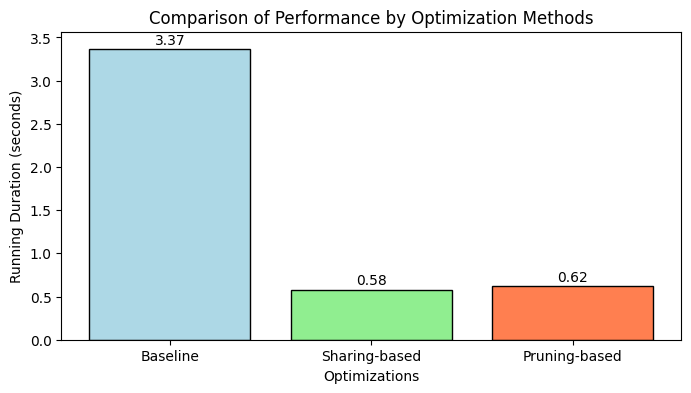

In [17]:
import matplotlib.pyplot as plt

methods = ['Baseline', 'Sharing-based', 'Pruning-based']
durations = [duration_baseline, duration_sharing, duration_pruning]

plt.figure(figsize=(8, 4))
bar_colors = ['lightblue', 'lightgreen', 'coral']
bars = plt.bar(methods, durations, edgecolor='black', color=bar_colors)

plt.xlabel('Optimizations')
plt.ylabel('Running Duration (seconds)')
plt.title('Comparison of Performance by Optimization Methods')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.02, f'{height:.2f}', ha='center', va='bottom')

plt.ylim(0, max(durations) + 0.2)
plt.show()

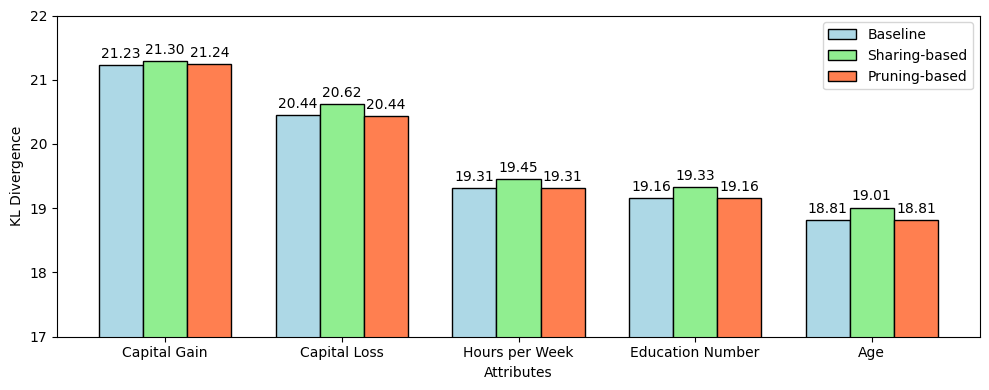

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Fixed these attributes for labels because output must be these, otherwise the algorithm is problematic.
categories = ['Capital Gain', 'Capital Loss', 'Hours per Week', 'Education Number', 'Age']
baseline_scores = [i[1] for i in result_baseline]
sharing_scores = [i[1] for i in result_sharing]
pruning_scores = [i[1] for i in result_pruning]

x = np.arange(len(categories))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 4))
rects1 = ax.bar(x - width, baseline_scores, width, label='Baseline', edgecolor='black', color='lightblue')
rects2 = ax.bar(x, sharing_scores, width, label='Sharing-based', edgecolor='black', color='lightgreen')
rects3 = ax.bar(x + width, pruning_scores, width, label='Pruning-based', edgecolor='black', color='coral')

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

ax.set_xlabel('Attributes')
ax.set_ylabel('KL Divergence')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

plt.ylim(17, 22)
plt.tight_layout()
plt.show()